In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix', 
    'xtick.labelsize' : 13,
    'xtick.top' : True,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'ytick.labelsize' : 13, 
    'ytick.right' : True, 
    'axes.labelsize' : 16,
    'legend.frameon': False,
    'legend.fontsize': 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600,
    'savefig.bbox' : 'tight'
})
torch.__version__

'1.7.1'

In [2]:
index = ['temp', 'm']
for i in range (256):
    index.append('s%d'%i)
p = pd.read_csv('isingspin_train.txt', sep=' ', header = 0, index_col=False, names=index) # 50 * 200: training
q = pd.read_csv('isingspin_val.txt', sep=' ', header = 0, index_col=False, names=index) # 20 * 200: validation
r = pd.read_csv('isingspin_test.txt', sep=' ', header = 0, index_col=False, names=index) # 20 * 200: test
p.sort_values(by=['temp'], axis=0, inplace=True)
q.sort_values(by=['temp'], axis=0, inplace=True)
r.sort_values(by=['temp'], axis=0, inplace=True)

# info
L = 16
size = L*L
out_node = 2

train_size = 50
val_size = 20
test_size = 20

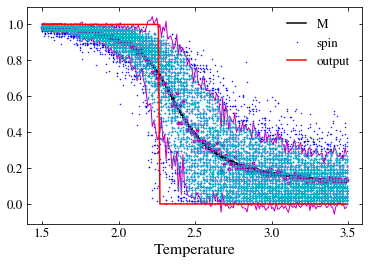

In [3]:
Tc = 2/np.log(1+np.sqrt(2))
stdev = 1.5

x1 = np.array(p[index[2:]])
y_train = np.array(p.temp<=Tc, dtype=float)
y1 = torch.FloatTensor(np.stack([y_train, 1-y_train], axis=1))

plt.plot(p.temp, p.m, 'k-', label='M')
abs_x = np.abs(np.average(x1, axis=1))
plt.plot(p.temp, abs_x, 'b.', ms = 1, label='spin')

new_x = abs_x.reshape(-1, train_size)
avg_new_x = np.mean(new_x, axis=1)
std_new_x = np.std(new_x, axis=1, ddof=1)
plt.plot(np.mean(np.array(p.temp).reshape(-1, train_size), axis=1), avg_new_x, 'm.')
plt.plot(np.mean(np.array(p.temp).reshape(-1, train_size), axis=1), avg_new_x+stdev*std_new_x, 'm-', lw=1)
plt.plot(np.mean(np.array(p.temp).reshape(-1, train_size), axis=1), avg_new_x-stdev*std_new_x, 'm-', lw=1)

# trim training data out of 1.5-stdev.
upper = np.repeat(avg_new_x+stdev*std_new_x, train_size)
lower = np.repeat(avg_new_x-stdev*std_new_x, train_size)
mask = (abs_x > lower) & (abs_x < upper)
plt.plot(p.temp[mask], abs_x[mask], 'c.', ms=1)
plt.plot(p.temp, y1[:,0], 'r-', label='output')

plt.xlabel('Temperature')
plt.legend()
plt.show()

# NN with single hidden layer

In [4]:
class Net(nn.Module): 
    def __init__(self, node = None, activate = None):
        super(Net, self).__init__()
        self.node = node
        self.W1 = nn.Linear(size, self.node, bias=False)
        self.b1 = nn.Linear(self.node, 1, bias=False)
        self.W2 = nn.Linear(self.node, out_node, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()
        
        if (activate==nn.Sigmoid or activate==nn.Tanh):
            nn.init.xavier_normal_(self.W1.weight)
            nn.init.xavier_normal_(self.W2.weight)
        else:
            nn.init.kaiming_normal_(self.W1.weight)
            nn.init.kaiming_normal_(self.W2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)
        
    def forward(self, x):
        return self.sig(self.W2(self.activate(self.W1(x)+self.b1.weight.data))+self.b2.weight.data)
    
    def loss1(self, output, y, reg):
        regular = reg*(torch.norm(self.W1.weight.data, p=1)+torch.norm(self.W2.weight.data, p=1)) # regularization l1
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss
    
    def loss2(self, output, y, reg):
        regular = reg*(torch.norm(self.W1.weight.data)**2+torch.norm(self.W2.weight.data)**2) # regularization l2
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss
    
    
    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

In [23]:
def middle1(func=None, h_node=None, reg = 1e-3, learning_rate = None):
    
    # Data processing
    x1, x2, x3 = np.array(p[index[2:]]), np.array(q[index[2:]]), np.array(r[index[2:]])
    x1, x2, x3 = torch.FloatTensor(x1), torch.FloatTensor(x2), torch.FloatTensor(x3)
    ## output node = 2
    y_train, y_val, y_test = np.array(p.temp<=Tc, dtype=float), np.array(q.temp<=Tc, dtype=float), np.array(r.temp<=Tc, dtype=float)
    y1, y2, y3 = np.stack([y_train, 1-y_train], axis=1), np.stack([y_val, 1-y_val], axis=1), np.stack([y_test, 1-y_test], axis=1)
    y1, y2, y3 = torch.FloatTensor(y1), torch.FloatTensor(y2), torch.FloatTensor(y3)
    x1, y1 = x1[mask], y1[mask]
    
    # create Neural Network with given activation function
    model = Net(node = h_node, activate = func)
    a = 3
    if func==nn.Sigmoid: 
        x1, x2, x3 = x1+1, x2+1, x3+1
        a = 8
    
    # Begin training and validation
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    n_epochs = int(15000 + a/learning_rate)
    train_loss, val_loss, test_acc = np.ones(n_epochs+1), np.ones(int(n_epochs/5)+1), np.zeros(n_epochs+1)
    model_optim, epoch_optim = [], []
    for epoch in range (n_epochs+1):
        loss = model.loss1(model.forward(x1), y1, reg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss[epoch] = loss.item()
        test_acc[epoch] = model.accuracy(model.forward(x3), y3)
        if epoch%5==0: 
            valid_loss = model.loss1(model.forward(x2), y2, reg).item()
            val_loss[int(epoch/5)] = valid_loss
        
        if epoch>=5 and valid_loss > val_loss[int(epoch/5)-1]: 
            #model_optim.append(model)
            epoch_optim.append(epoch)
    #model_optim.append(model)
    epoch_optim.append(epoch)
    
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    im = ax[1].imshow(np.array(model.W1.weight.data), aspect=size/h_node, cmap='Spectral')
    cb = plt.colorbar(im)
    
    # record training & validation
    ax[0].plot(np.arange(len(train_loss)), train_loss/np.max(val_loss), '-', label='train loss')
    ax[0].plot(np.arange(len(val_loss))*5, val_loss/np.max(val_loss), '-', label='validation')
    ax[0].plot(np.arange(len(test_acc)), test_acc, '-', label='test acc')
    print(epoch_optim[0])
    ax[0].set_xlabel('epoch')
    ax[0].set_ylim(0)
    ax[0].legend()
    plt.show()
       
    return model, x3, y3

In [24]:
def middle2(func=None, h_node=None, reg = 1e-3, learning_rate = None):
    
    # Data processing
    x1, x2, x3 = np.array(p[index[2:]]), np.array(q[index[2:]]), np.array(r[index[2:]])
    x1, x2, x3 = torch.FloatTensor(x1), torch.FloatTensor(x2), torch.FloatTensor(x3)
    ## output node = 2
    y_train, y_val, y_test = np.array(p.temp<=Tc, dtype=float), np.array(q.temp<=Tc, dtype=float), np.array(r.temp<=Tc, dtype=float)
    y1, y2, y3 = np.stack([y_train, 1-y_train], axis=1), np.stack([y_val, 1-y_val], axis=1), np.stack([y_test, 1-y_test], axis=1)
    y1, y2, y3 = torch.FloatTensor(y1), torch.FloatTensor(y2), torch.FloatTensor(y3)
    x1, y1 = x1[mask], y1[mask]
    
    # create Neural Network with given activation function
    model = Net(node = h_node, activate = func)
    a = 3
    if func==nn.Sigmoid: 
        x1, x2, x3 = x1+1, x2+1, x3+1
        a = 8
    
    # Begin training and validation
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    n_epochs = int(15000 + a/learning_rate)
    train_loss, val_loss, test_acc = np.ones(n_epochs+1), np.ones(int(n_epochs/5)+1), np.zeros(n_epochs+1)
    model_optim, epoch_optim = [], []
    for epoch in range (n_epochs+1):
        loss = model.loss2(model.forward(x1), y1, reg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss[epoch] = loss.item()
        test_acc[epoch] = model.accuracy(model.forward(x3), y3)
        if epoch%5==0: 
            valid_loss = model.loss2(model.forward(x2), y2, reg).item()
            val_loss[int(epoch/5)] = valid_loss
        
        if epoch>=5 and valid_loss > val_loss[int(epoch/5)-1]: 
            #model_optim.append(model)
            epoch_optim.append(epoch)
    #model_optim.append(model)
    epoch_optim.append(epoch)
    
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    im = ax[1].imshow(np.array(model.W1.weight.data), aspect=size/h_node, cmap='Spectral')
    cb = plt.colorbar(im)
    
    # record training & validation
    ax[0].plot(np.arange(len(train_loss)), train_loss/np.max(val_loss), '-', label='train loss')
    ax[0].plot(np.arange(len(val_loss))*5, val_loss/np.max(val_loss), '-', label='validation')
    ax[0].plot(np.arange(len(test_acc)), test_acc, '-', label='test acc')
    print(epoch_optim[0])
    ax[0].set_xlabel('epoch')
    ax[0].set_ylim(0)
    ax[0].legend()
    plt.show()
       
    return model, x3, y3

In [25]:
def plotting(lr, func, middle):
    print("lr =",lr)
    reg = 1e-3
    model_r, x3, y3 = middle(func = func, h_node = 100, learning_rate = lr)
    
    output = model_r.forward(x3).data[:,0]
    plt.plot(r.temp, r.m, 'k-')
    if func==nn.Sigmoid:
        plt.plot(r.temp, np.abs(np.average(x3-1, axis=1)), 'c.', ms=3, label='spin')
    else: plt.plot(r.temp, np.abs(np.average(x3, axis=1)), 'c.', ms=3, label='spin')
    plt.plot(r.temp, output, 'b.', ms=2, label='out')
    plt.plot(np.mean(np.array(r.temp).reshape(-1, test_size), axis=1), 
             np.mean(np.array(output).reshape(-1, test_size), axis=1), 'r.-', label='avg_out')
    plt.ylabel('output')
    plt.xlabel('Temperature')
    plt.show()
    
    if middle==middle1:
        print('test loss = %.8f, test acc = %.8f'
              %(model_r.loss1(model_r.forward(x3), y3, reg).item(), model_r.accuracy(model_r.forward(x3), y3)))
    if middle==middle2:
        print('test loss = %.8f, test acc = %.8f'
              %(model_r.loss2(model_r.forward(x3), y3, reg).item(), model_r.accuracy(model_r.forward(x3), y3)))

lr = 0.1
160


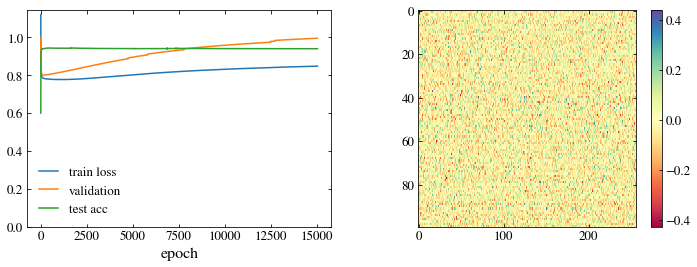

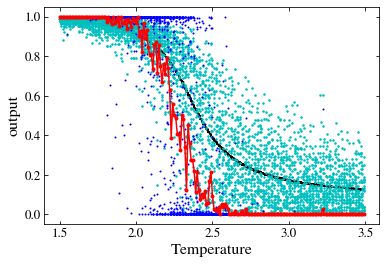

test loss = 2.46069622, test acc = 0.94037500
lr = 0.01
1610


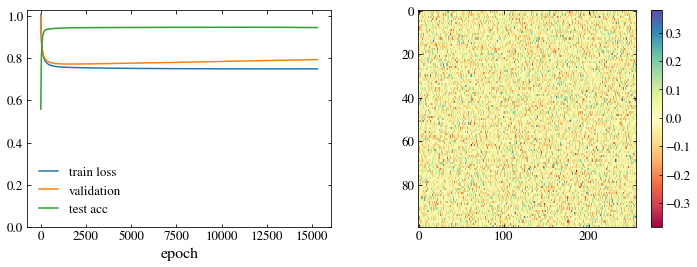

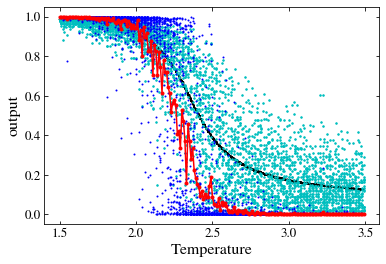

test loss = 2.04996777, test acc = 0.94387500
lr = 0.001
11045


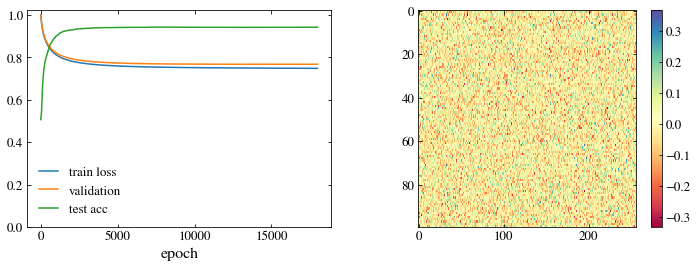

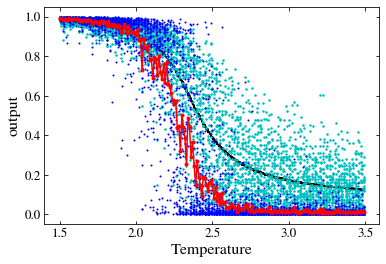

test loss = 1.99073851, test acc = 0.94250000
lr = 0.0001
45000


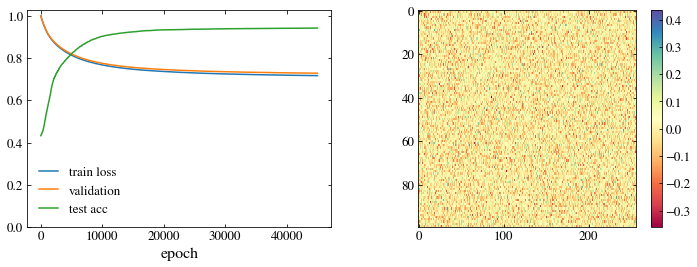

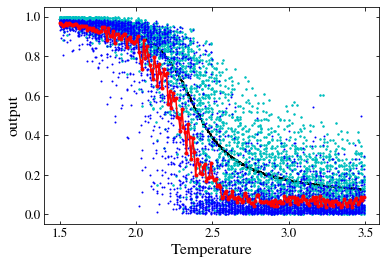

test loss = 2.01739836, test acc = 0.94175000
lr = 1e-05
315000


/home/hyejin/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


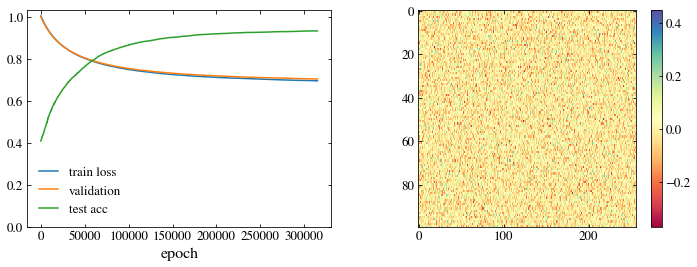

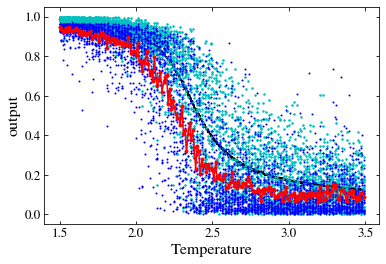

test loss = 2.04191494, test acc = 0.93275000


In [20]:
for i in range (5):
    plotting(10**(-1-i), nn.ReLU, middle1)

lr = 0.1
275


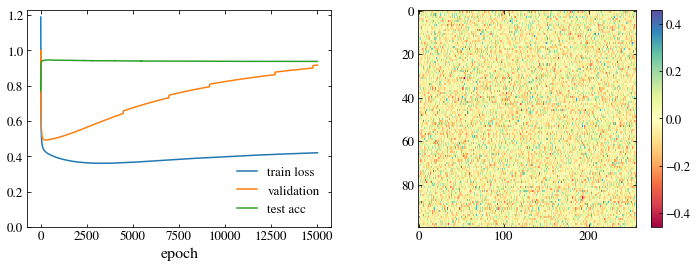

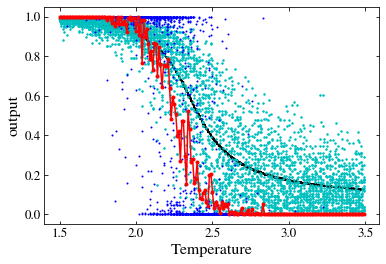

test loss = 0.65760851, test acc = 0.93812500
lr = 0.01
2495


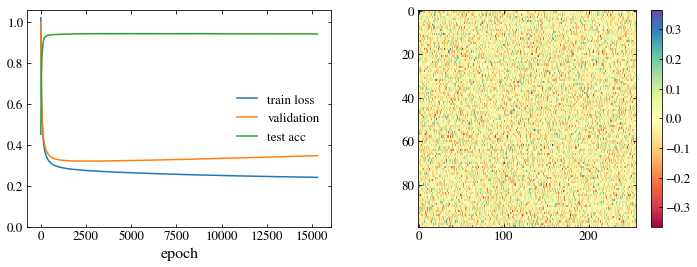

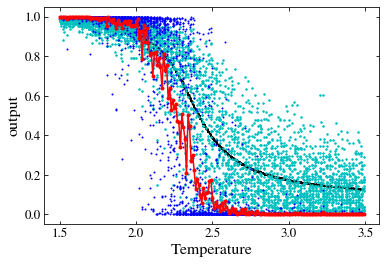

test loss = 0.38384545, test acc = 0.94225000
lr = 0.001
18000


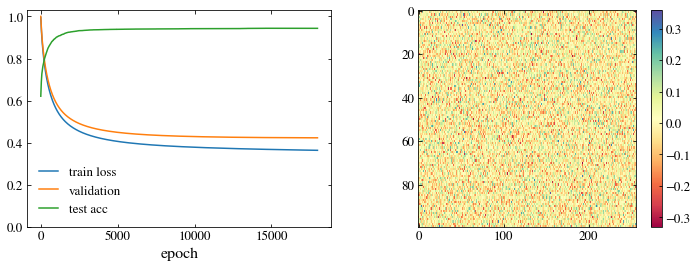

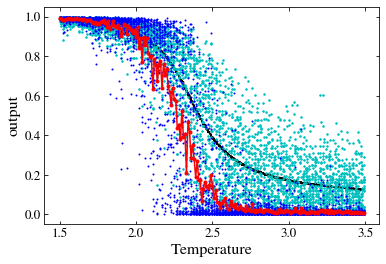

test loss = 0.35550040, test acc = 0.94337500
lr = 0.0001
45000


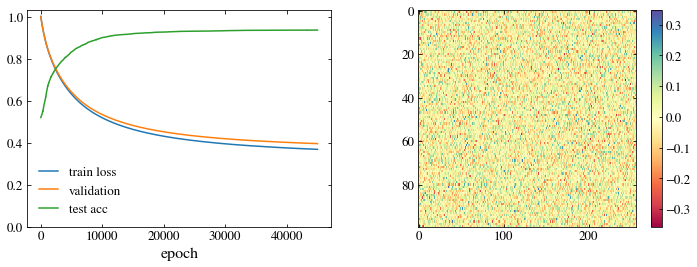

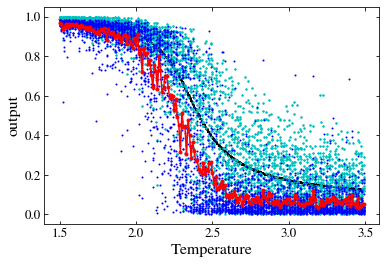

test loss = 0.38932782, test acc = 0.93762500
lr = 1e-05
315000


/home/hyejin/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


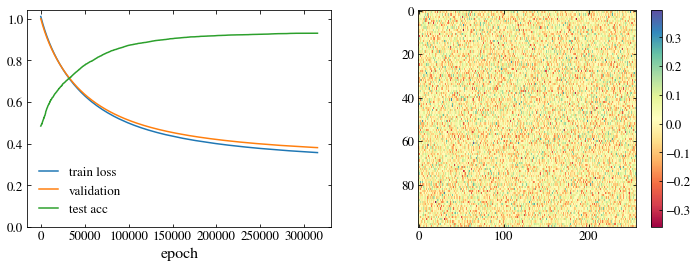

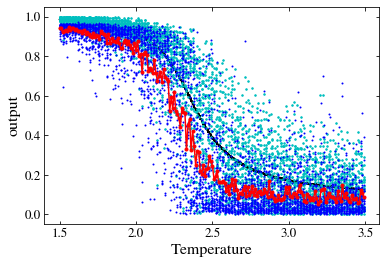

test loss = 0.41513389, test acc = 0.93012500


In [21]:
for i in range (5):
    plotting(10**(-1-i), nn.ReLU, middle2)

lr = 0.1
900


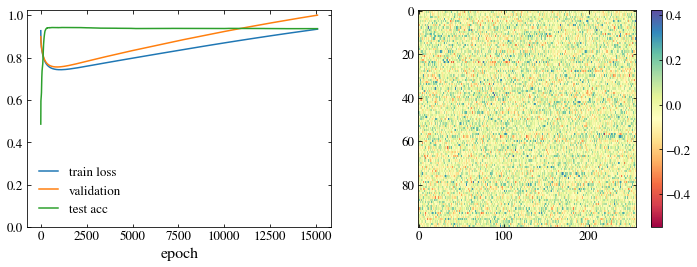

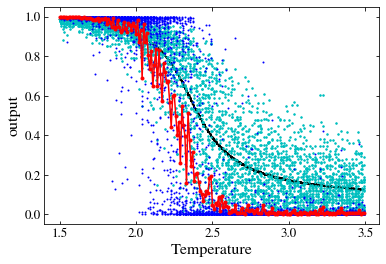

test loss = 2.50029469, test acc = 0.93637500
lr = 0.01
8345


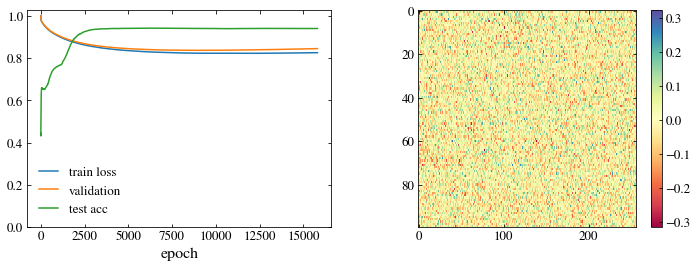

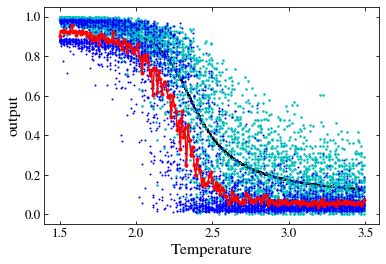

test loss = 1.92335463, test acc = 0.94087500
lr = 0.001
23000


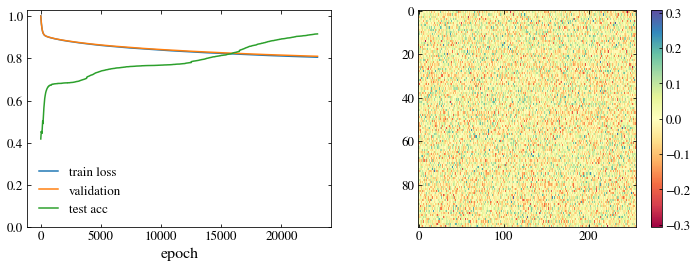

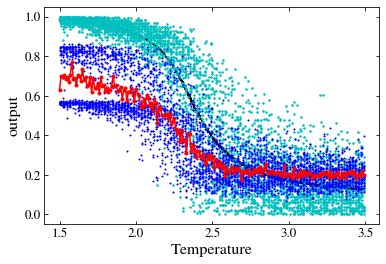

test loss = 1.96280468, test acc = 0.91550000
lr = 0.0001
95000


/home/hyejin/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


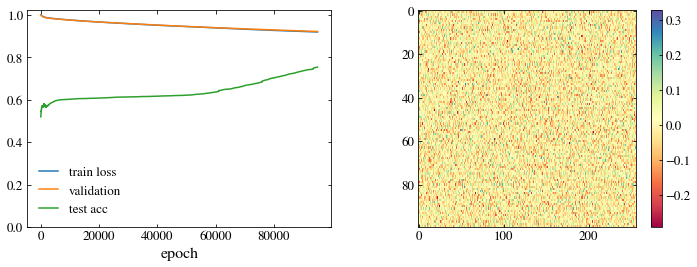

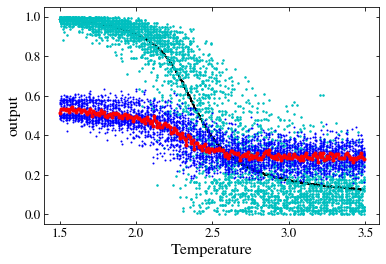

test loss = 2.07569718, test acc = 0.75450000
lr = 1e-05


KeyboardInterrupt: 

In [26]:
for i in range (5):
    plotting(10**(-1-i), nn.Sigmoid, middle1)

lr = 0.1
1445


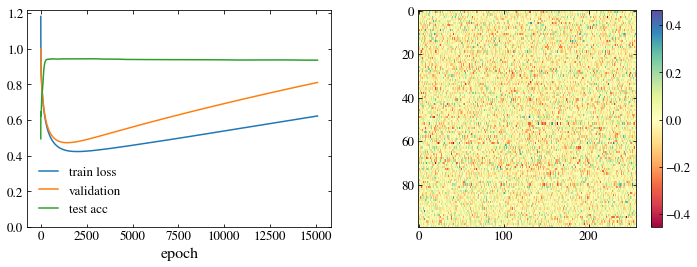

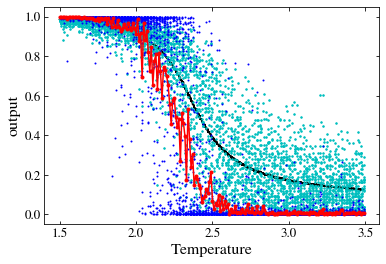

test loss = 0.69906938, test acc = 0.93637500
lr = 0.01
14290


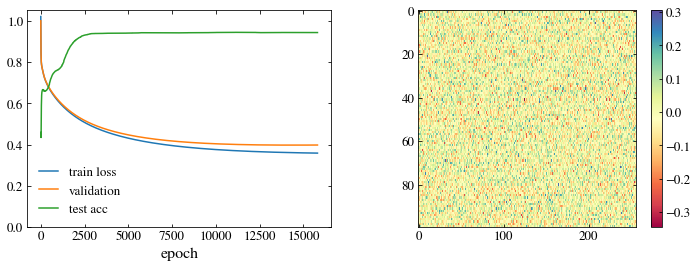

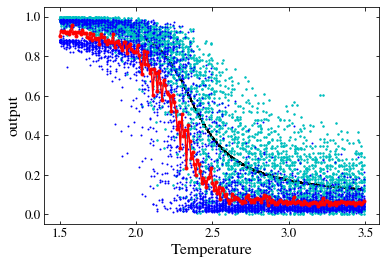

test loss = 0.41099769, test acc = 0.94312500
lr = 0.001
23000


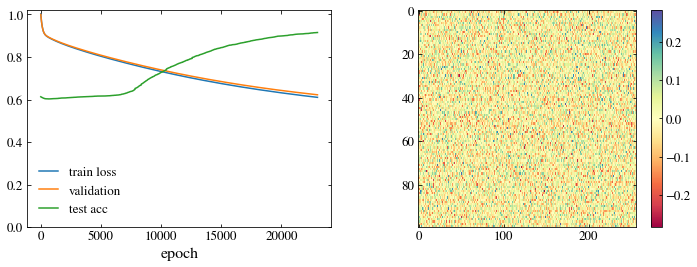

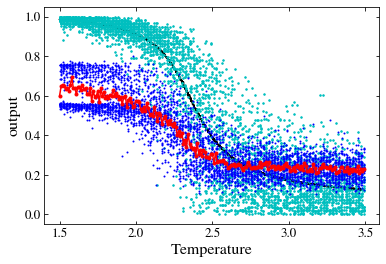

test loss = 0.56744492, test acc = 0.91500000
lr = 0.0001


KeyboardInterrupt: 

In [27]:
for i in range (5):
    plotting(10**(-1-i), nn.Sigmoid, middle2)